# Download historical data

In [92]:
import matplotlib.pyplot as plt
from arch import arch_model
import pandas_ta
import pandas as pd
import numpy as np
import os
import yfinance as yf
from datetime import datetime, date, timedelta
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from scipy.signal import argrelextrema

%matplotlib inline

In [93]:
import zstandard as zstd
import databento as db
import talib

dir_path_1h = "/Users/juju/Library/CloudStorage/GoogleDrive-jujuaria@gmail.com/My Drive/trade_data/GLBX-20250224-RSQQHMB9G7"
dir_path_1m = "/Users/juju/Library/CloudStorage/GoogleDrive-jujuaria@gmail.com/My Drive/trade_data/GLBX-20250301-7C5JWPSUX8"


filename_1h = os.path.join(dir_path_1h, "glbx-mdp3-20240824-20250223.ohlcv-1h.dbn.zst")
filename_1m = os.path.join(dir_path_1m, "glbx-mdp3-20240901-20250228.ohlcv-1m.dbn.zst")

dbn_file_1h = os.path.join(dir_path_1h, "es_futures_1h.dbn")
dbn_file_1m = os.path.join(dir_path_1h, "es_futures_1m.dbn")

In [94]:
# Open and decompress the .zst file
with open(filename_1h, "rb") as compressed, open(dbn_file_1h, "wb") as decompressed:
    dctx = zstd.ZstdDecompressor()
    dctx.copy_stream(compressed, decompressed)

df_1h = db.DBNStore.from_file(dbn_file_1h).to_df()




In [95]:
# Open and decompress the .zst file
with open(filename_1m, "rb") as compressed, open(dbn_file_1m, "wb") as decompressed:
    dctx = zstd.ZstdDecompressor()
    dctx.copy_stream(compressed, decompressed)

df_1m = db.DBNStore.from_file(dbn_file_1m).to_df()

In [96]:
df_1m

,rtype,publisher_id,instrument_id,open,high,low,close,volume,symbol
ts_event,,,,,,,,,
2024-09-01 22:00:00+00:00,33,1,118,5656.25,5659.00,5656.25,5658.25,497,ESU4
2024-09-01 22:00:00+00:00,33,1,183748,5719.00,5719.75,5718.25,5719.75,11,ESZ4
2024-09-01 22:00:00+00:00,33,1,46995,61.05,61.05,61.05,61.05,2,ESU4-ESZ4
2024-09-01 22:01:00+00:00,33,1,46995,61.05,61.05,61.05,61.05,3,ESU4-ESZ4
2024-09-01 22:01:00+00:00,33,1,183748,5720.00,5720.00,5720.00,5720.00,2,ESZ4
...,...,...,...,...,...,...,...,...,...
2025-02-28 21:58:00+00:00,33,1,5002,5959.00,5959.50,5958.00,5958.50,596,ESH5
2025-02-28 21:58:00+00:00,33,1,18812,56.20,56.20,56.20,56.20,1,ESH5-ESM5
2025-02-28 21:59:00+00:00,33,1,5002,5958.50,5958.75,5957.50,5958.00,569,ESH5


In [97]:
df = df_1m.reset_index()

# Define contract periods
# Define contract periods (converted to UTC timestamps)
contract_periods = {
    "ESU4": (pd.Timestamp("2024-08-25", tz="UTC"), pd.Timestamp("2024-09-15", tz="UTC")),  # Sep contract
    "ESZ4": (pd.Timestamp("2024-09-16", tz="UTC"), pd.Timestamp("2025-12-15", tz="UTC")),  # Dec contract
    "ESH5": (pd.Timestamp("2024-12-16", tz="UTC"), pd.Timestamp("2025-03-15", tz="UTC")),  # Mar contract
    
}


# Filter out non-tradingview symbols (like ESU4-ESZ4 spreads)
valid_symbols = list(contract_periods.keys())  # ['ESU4', 'ESZ4']
df = df[df["symbol"].isin(valid_symbols)]

# Apply date filters per contract
filtered_df = pd.concat([
    df[(df["symbol"] == symbol) & 
       (df["ts_event"]>= pd.to_datetime(start)) & 
       (df["ts_event"]<= pd.to_datetime(end))]
    for symbol, (start, end) in contract_periods.items()
])


In [98]:
filtered_df

,ts_event,rtype,publisher_id,instrument_id,open,high,low,close,volume,symbol
0,2024-09-01 22:00:00+00:00,33,1,118,5656.25,5659.00,5656.25,5658.25,497,ESU4
5,2024-09-01 22:01:00+00:00,33,1,118,5658.25,5659.75,5658.00,5659.25,397,ESU4
6,2024-09-01 22:02:00+00:00,33,1,118,5659.25,5660.50,5659.25,5660.00,156,ESU4
7,2024-09-01 22:03:00+00:00,33,1,118,5659.75,5660.00,5658.75,5659.25,157,ESU4
10,2024-09-01 22:04:00+00:00,33,1,118,5659.50,5659.50,5659.00,5659.50,69,ESU4
...,...,...,...,...,...,...,...,...,...,...
285205,2025-02-28 21:55:00+00:00,33,1,5002,5959.50,5959.50,5958.00,5958.50,423,ESH5
285207,2025-02-28 21:56:00+00:00,33,1,5002,5958.50,5959.50,5957.75,5959.50,530,ESH5
285208,2025-02-28 21:57:00+00:00,33,1,5002,5959.50,5960.00,5958.75,5959.00,416,ESH5
285210,2025-02-28 21:58:00+00:00,33,1,5002,5959.00,5959.50,5958.00,5958.50,596,ESH5


In [99]:
df_1m = filtered_df
df_1m.set_index("ts_event", inplace=True)
df_1m = df_1m.sort_index()


In [100]:
# Resample 1-minute data into 15-minute OHLCV format
df_15m = df_1m.resample("15T").agg({
    "open": "first",
    "high": "max",
    "low": "min",
    "close": "last",
    "volume": "sum"
})

# Drop NaNs caused by resampling
df_15m.dropna(inplace=True)



/var/folders/s4/fs8csczs30v9tbl343gq9lr00000gn/T/ipykernel_59825/3999806385.py:2: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  df_15m = df_1m.resample("15T").agg({


In [101]:
# Create a column for the previous 15-minute close
df_15m["prev_close"] = df_15m["close"].shift(1)

# Create the target variable: 1 if next close > previous close, 0 otherwise
df_15m["Target"] = (df_15m["close"] > df_15m["prev_close"]).astype(int)

# Drop NaNs created by shifting
df_15m.dropna(inplace=True)

In [102]:
df_15m

,open,high,low,close,volume,prev_close,Target
ts_event,,,,,,,
2024-09-01 22:15:00+00:00,5657.25,5657.50,5655.25,5655.50,537,5657.00,0
2024-09-01 22:30:00+00:00,5655.25,5656.00,5653.75,5654.00,925,5655.50,0
2024-09-01 22:45:00+00:00,5654.00,5654.25,5652.00,5653.25,995,5654.00,0
2024-09-01 23:00:00+00:00,5653.25,5654.50,5652.75,5653.50,784,5653.25,1
2024-09-01 23:15:00+00:00,5653.50,5655.00,5653.25,5654.25,453,5653.50,1
...,...,...,...,...,...,...,...
2025-02-28 20:45:00+00:00,5922.00,5971.00,5919.25,5964.00,309435,5922.00,1
2025-02-28 21:00:00+00:00,5964.25,5965.75,5953.75,5957.25,111076,5964.00,0
2025-02-28 21:15:00+00:00,5957.50,5962.50,5955.25,5958.00,14401,5957.25,1


In [103]:
df_resampled = df_15m.reset_index()

In [104]:

# Returns & Volatility
df_resampled["returns"] = df_resampled["close"].pct_change()
df_resampled["volatility"] = df_resampled["returns"].rolling(5).std()

# ATR (Volatility)
def compute_atr(high, low, close, window=14):
    tr1 = high - low
    tr2 = abs(high - close.shift(1))
    tr3 = abs(low - close.shift(1))
    tr = pd.concat([tr1, tr2, tr3], axis=1).max(axis=1)
    return tr.rolling(window=window).mean()

df_resampled["atr"] = compute_atr(df_resampled["high"], df_resampled["low"], df_resampled["close"])

# Relative Volume (Volume Spike Detection)
df_resampled["avg_vol"] = df_resampled["volume"].rolling(20).mean()
df_resampled["rel_vol"] = df_resampled["volume"] / df_resampled["avg_vol"]

# Momentum Indicators (Past Trend)
df_resampled["sma_5"] = df_resampled["close"].rolling(5).mean()
df_resampled["sma_15"] = df_resampled["close"].rolling(15).mean()
df_resampled["ema_20"] = df_resampled["close"].ewm(span=20).mean()

# RSI (Past Data)
def compute_rsi(series, window=14):
    delta = series.diff()
    gain = delta.where(delta > 0, 0).rolling(window=window).mean()
    loss = -delta.where(delta < 0, 0).rolling(window=window).mean()
    rs = gain / loss
    return 100 - (100 / (1 + rs))

df_resampled["rsi"] = compute_rsi(df_resampled["close"])

# Candlestick Patterns (Past Behavior)
df_resampled["bullish_engulfing"] = (
    (df_resampled["close"] > df_resampled["open"]) & 
    (df_resampled["close"].shift(1) < df_resampled["open"].shift(1))
)

df_resampled["bearish_engulfing"] = (
    (df_resampled["close"] < df_resampled["open"]) & 
    (df_resampled["close"].shift(1) > df_resampled["open"].shift(1))
)

# === Use Past Data as Features ===
lags = [1, 2, 3, 5, 10, 15]
for lag in lags:
    df_resampled[f"close_lag_{lag}"] = df_resampled["close"].shift(lag)
    df_resampled[f"volume_lag_{lag}"] = df_resampled["volume"].shift(lag)
    df_resampled[f"atr_lag_{lag}"] = df_resampled["atr"].shift(lag)
    df_resampled[f"rsi_lag_{lag}"] = df_resampled["rsi"].shift(lag)

# Drop NaN values due to shifting & rolling calculations
df_resampled.dropna(inplace=True)



In [ ]:
lag_features = df.filter(like="_lag").columns
X = df[lag_features]

Index(['ts_event', 'open', 'high', 'low', 'close', 'volume', 'prev_close',
       'Target', 'returns', 'volatility', 'atr', 'avg_vol', 'rel_vol', 'sma_5',
       'sma_15', 'ema_20', 'rsi', 'bullish_engulfing', 'bearish_engulfing',
       'close_lag_1', 'volume_lag_1', 'atr_lag_1', 'rsi_lag_1', 'close_lag_2',
       'volume_lag_2', 'atr_lag_2', 'rsi_lag_2', 'close_lag_3', 'volume_lag_3',
       'atr_lag_3', 'rsi_lag_3', 'close_lag_5', 'volume_lag_5', 'atr_lag_5',
       'rsi_lag_5', 'close_lag_10', 'volume_lag_10', 'atr_lag_10',
       'rsi_lag_10', 'close_lag_15', 'volume_lag_15', 'atr_lag_15',
       'rsi_lag_15'],
      dtype='object')

/opt/anaconda3/lib/python3.11/site-packages/pandas/core/algorithms.py:1743: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  return lib.map_infer(values, mapper, convert=convert)
/opt/anaconda3/lib/python3.11/site-packages/pandas/core/algorithms.py:1743: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  return lib.map_infer(values, mapper, convert=convert)
/opt/anaconda3/lib/python3.11/site-packages/pandas/core/algorithms.py:1743: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  return lib.map_infer(values, mapper, convert=convert)
/opt/anaconda3/lib/python3.11/site-packages/pandas/core/algorithms.py:1743: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseD

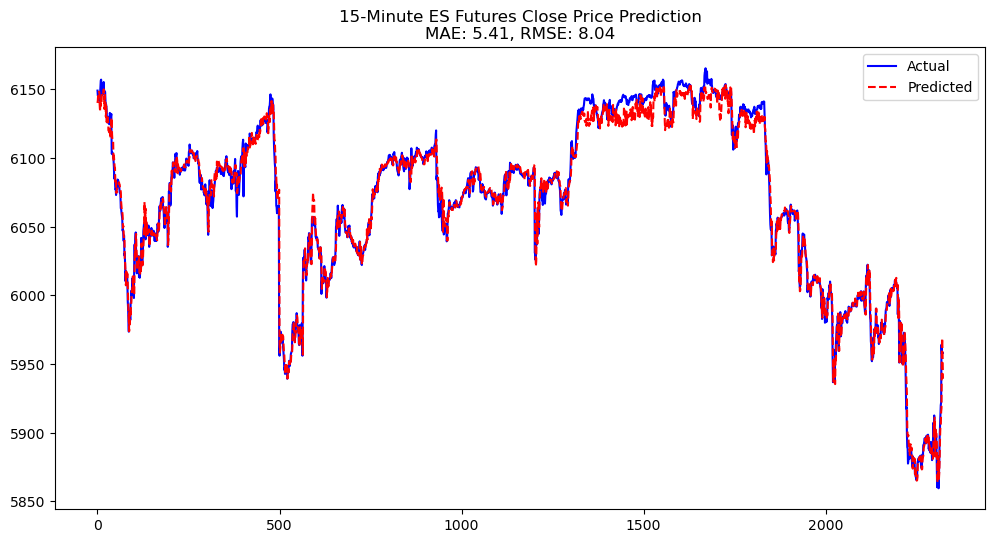

Mean Absolute Error (MAE): 5.41
Root Mean Squared Error (RMSE): 8.04


In [107]:

# Define target and features
lag_features =df_resampled.filter(like="_lag").columns
X = df_resampled[lag_features]
y = df_resampled["close"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Normalize data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train XGBoost Model
xgb_model = xgb.XGBRegressor(objective="reg:squarederror", n_estimators=200, learning_rate=0.05)
xgb_model.fit(X_train_scaled, y_train)

# Predict on test set
y_pred = xgb_model.predict(X_test_scaled)


# Evaluate model
mae = mean_absolute_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)

# Plot results
plt.figure(figsize=(12, 6))
plt.plot(y_test.values, label="Actual", color="blue")
plt.plot(y_pred, label="Predicted", color="red", linestyle="dashed")
plt.legend()
plt.title(f"15-Minute ES Futures Close Price Prediction\nMAE: {mae:.2f}, RMSE: {rmse:.2f}")
plt.show()

# Print metrics
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")

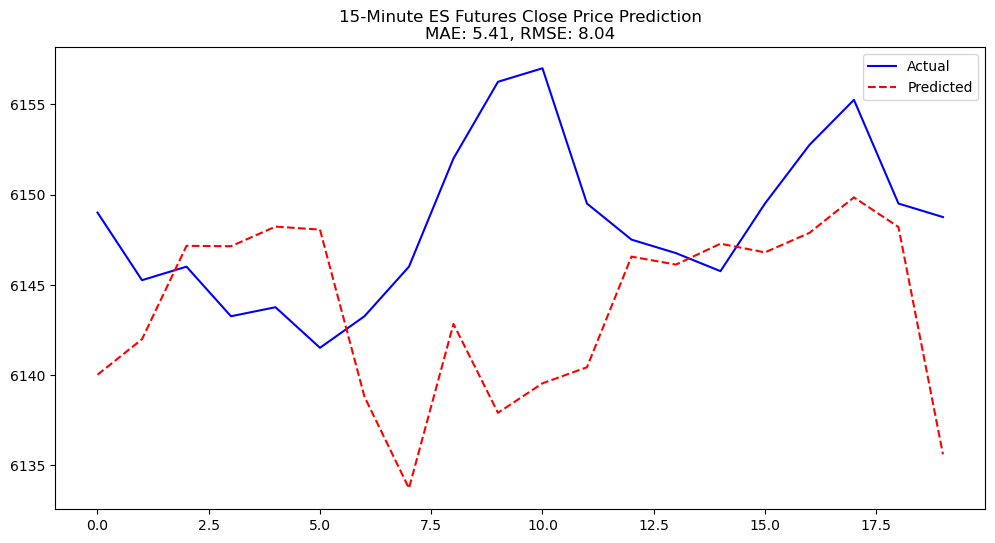

In [108]:
plt.figure(figsize=(12, 6))
plt.plot(y_test[:20].values, label="Actual", color="blue")
plt.plot(y_pred[:20], label="Predicted", color="red", linestyle="dashed")
plt.legend()
plt.title(f"15-Minute ES Futures Close Price Prediction\nMAE: {mae:.2f}, RMSE: {rmse:.2f}")
plt.show()

In [ ]:
# === Fix Support & Resistance Mapping ===
def find_support_resistance(prices, lookback):
    """Finds past support & resistance levels and maps them back to the full dataset."""
    high_idx = argrelextrema(prices.values, np.greater, order=lookback)[0]
    low_idx = argrelextrema(prices.values, np.less, order=lookback)[0]

    support_levels = pd.Series(index=prices.index, dtype=float)
    resistance_levels = pd.Series(index=prices.index, dtype=float)

    support_levels.iloc[low_idx] = prices.iloc[low_idx]
    resistance_levels.iloc[high_idx] = prices.iloc[high_idx]

    # Forward-fill so every row has a level
    support_levels.fillna(method='ffill', inplace=True)
    resistance_levels.fillna(method='ffill', inplace=True)

    return support_levels, resistance_levels

# Apply function
backtest_df["support"], backtest_df["resistance"] = find_support_resistance(backtest_df["predicted_close"], lookback)

/var/folders/s4/fs8csczs30v9tbl343gq9lr00000gn/T/ipykernel_59825/1192944451.py:70: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  support_levels.fillna(method='ffill', inplace=True)
/var/folders/s4/fs8csczs30v9tbl343gq9lr00000gn/T/ipykernel_59825/1192944451.py:71: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  resistance_levels.fillna(method='ffill', inplace=True)


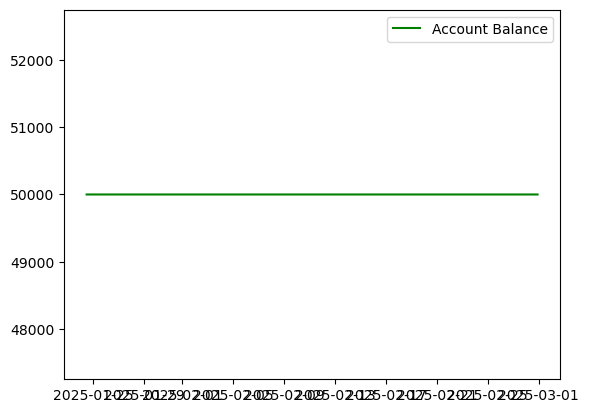

In [89]:
from scipy.signal import argrelextrema

# === Define Trading Parameters ===
initial_balance = 50000
max_daily_drawdown = 1200  # Per-day max loss
contract_size = 50
risk_per_trade = 0.005  # 0.5% of balance
lookback = 20  # Period to find local S/R levels

# === Dynamic Drawdown Settings ===
min_balance = 47500  # Minimum allowed balance at start
trailing_drawdown = 2500
drawdown_threshold = 53000  # Once reached, max drawdown stops trailing
hard_floor_above_53k = 50500  # Once >53k, balance must stay above 50.5k
highest_balance = initial_balance  # Track peak balance

# Ensure the backtest dataset contains required columns
if "ts_event" not in backtest_df.columns or "close" not in backtest_df.columns or "predicted_close" not in backtest_df.columns:
    raise ValueError("Backtest dataset is missing required columns. Ensure data preprocessing is correct.")

# === Backtest Initialization ===
backtest_df = df_resampled.iloc[len(y_train):].copy()
backtest_df["predicted_close"] = y_pred
backtest_df["position"] = 0
backtest_df["pnl"] = 0
backtest_df["daily_pnl"] = 0
backtest_df["balance"] = initial_balance

current_balance = initial_balance
daily_loss = 0
trade_count = 0
win_count = 0
loss_count = 0
equity_curve = [initial_balance]

# === Calculate RSI & ATR on Predicted Values ===
def compute_rsi(series, window=14):
    """Computes RSI based on predicted values."""
    delta = series.diff()
    gain = delta.where(delta > 0, 0).rolling(window=window).mean()
    loss = -delta.where(delta < 0, 0).rolling(window=window).mean()
    rs = gain / loss
    return 100 - (100 / (1 + rs))

def compute_atr(high, low, close, window=14):
    """Computes ATR based on predicted values."""
    tr1 = high - low
    tr2 = abs(high - close.shift(1))
    tr3 = abs(low - close.shift(1))
    tr = pd.concat([tr1, tr2, tr3], axis=1).max(axis=1)
    return tr.rolling(window=window).mean()

# Compute RSI & ATR using predicted close
backtest_df["rsi"] = compute_rsi(backtest_df["predicted_close"])
backtest_df["atr"] = compute_atr(backtest_df["high"], backtest_df["low"], backtest_df["predicted_close"])

# === Fix Support & Resistance Mapping ===
def find_support_resistance(prices, lookback):
    """Finds past support & resistance levels and maps them back to the full dataset."""
    high_idx = argrelextrema(prices.values, np.greater, order=lookback)[0]
    low_idx = argrelextrema(prices.values, np.less, order=lookback)[0]

    support_levels = pd.Series(index=prices.index, dtype=float)
    resistance_levels = pd.Series(index=prices.index, dtype=float)

    support_levels.iloc[low_idx] = prices.iloc[low_idx]
    resistance_levels.iloc[high_idx] = prices.iloc[high_idx]

    # Forward-fill so every row has a level
    support_levels.fillna(method='ffill', inplace=True)
    resistance_levels.fillna(method='ffill', inplace=True)

    return support_levels, resistance_levels

# Apply function
backtest_df["support"], backtest_df["resistance"] = find_support_resistance(backtest_df["predicted_close"], lookback)

# === Trading Strategy ===
for i in range(lookback, len(backtest_df)):
    date = backtest_df.iloc[i]["ts_event"].date()
    prev_date = backtest_df.iloc[i - 1]["ts_event"].date()

    if date != prev_date:
        daily_loss = 0

    actual_close = backtest_df.iloc[i]["close"]
    predicted_close = backtest_df.iloc[i]["predicted_close"]
    rsi = backtest_df.iloc[i]["rsi"]
    atr = backtest_df.iloc[i]["atr"]

    nearest_support = backtest_df["support"].iloc[i]
    nearest_resistance = backtest_df["resistance"].iloc[i]

    # **Dynamic Drawdown**
    if current_balance > highest_balance:
        highest_balance = current_balance
        min_balance = max(min_balance, highest_balance - trailing_drawdown)

    if highest_balance >= drawdown_threshold:
        min_balance = max(hard_floor_above_53k, min_balance)

    if current_balance < min_balance:
        continue  

    # **Trade Logic (Now Based on Predicted Values)**
    position = 0
    if predicted_close > actual_close and rsi > 50 and nearest_support and actual_close > nearest_support - (2 * atr):
        position = 1  # Long
        stop_loss = nearest_support - (0.8 * atr)
        take_profit = actual_close + (1.5 * atr)
    elif predicted_close < actual_close and rsi < 50 and nearest_resistance and actual_close < nearest_resistance + (2 * atr):
        position = -1  # Short
        stop_loss = nearest_resistance + (0.8 * atr)
        take_profit = actual_close - (1.5 * atr)

    # **Execute Trade**
    pnl = 0
    if position == 1 and actual_close >= take_profit:
        pnl = (take_profit - actual_close) * contract_size
    elif position == -1 and actual_close <= take_profit:
        pnl = (actual_close - take_profit) * contract_size

    # **Update Balance**
    backtest_df.at[i, "pnl"] = pnl
    current_balance += pnl
    backtest_df.at[i, "balance"] = current_balance
    equity_curve.append(current_balance)

# Ensure timestamps are in correct datetime format
backtest_df["ts_event"] = pd.to_datetime(backtest_df["ts_event"], errors="coerce")

# Drop NaT values to avoid plotting issues
backtest_df = backtest_df.dropna(subset=["ts_event"])

# Convert timezone-aware timestamps to naive timestamps (if applicable)
backtest_df["ts_event"] = backtest_df["ts_event"].dt.tz_localize(None)
# === Plot Results ===
plt.plot(backtest_df["ts_event"], backtest_df["balance"], label="Account Balance", color="green")
plt.legend()
plt.show()



In [90]:
backtest_df

,ts_event,open,high,low,close,volume,prev_close,Target,returns,volatility,...,close_lag_3,close_lag_5,close_lag_10,predicted_close,position,pnl,daily_pnl,balance,support,resistance
9317,2025-01-24 11:30:00,6141.75,6144.00,6140.50,6143.50,1863.0,6141.75,1.0,0.000285,0.000424,...,6143.25,6142.50,6147.25,6143.923828,0.0,0.0,0.0,50000.0,NaN,NaN
9318,2025-01-24 11:45:00,6143.50,6144.50,6142.00,6144.25,3505.0,6143.50,1.0,0.000122,0.000309,...,6142.75,6139.50,6147.75,6143.479004,0.0,0.0,0.0,50000.0,NaN,NaN
9319,2025-01-24 12:00:00,6144.50,6146.25,6143.50,6145.00,3280.0,6144.25,1.0,0.000122,0.000179,...,6141.75,6143.25,6146.25,6143.680176,0.0,0.0,0.0,50000.0,NaN,NaN
9320,2025-01-24 12:15:00,6145.00,6149.25,6144.75,6149.00,2918.0,6145.00,1.0,0.000651,0.000298,...,6143.50,6142.75,6145.50,6148.661133,0.0,0.0,0.0,50000.0,NaN,NaN
9321,2025-01-24 12:30:00,6148.75,6149.00,6144.75,6145.25,2661.0,6149.00,0.0,-0.000610,0.000459,...,6144.25,6141.75,6144.25,6145.561523,0.0,0.0,0.0,50000.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11638,2025-02-28 20:45:00,5922.00,5971.00,5919.25,5964.00,309435.0,5922.00,1.0,0.007092,0.002744,...,5910.75,5897.50,5870.75,5965.930176,0.0,0.0,0.0,50000.0,5853.425293,5965.930176
11639,2025-02-28 21:00:00,5964.25,5965.75,5953.75,5957.25,111076.0,5964.00,0.0,-0.001132,0.003136,...,5920.00,5904.50,5883.00,5953.608887,0.0,0.0,0.0,50000.0,5853.425293,5965.930176
11640,2025-02-28 21:15:00,5957.50,5962.50,5955.25,5958.00,14401.0,5957.25,1.0,0.000126,0.003217,...,5922.00,5910.75,5859.50,5961.401367,0.0,0.0,0.0,50000.0,5853.425293,5965.930176
11641,2025-02-28 21:30:00,5957.75,5959.50,5956.75,5958.00,5870.0,5958.00,0.0,0.000000,0.003296,...,5964.00,5920.00,5868.25,5959.069336,0.0,0.0,0.0,50000.0,5853.425293,5965.930176


In [57]:
win_rate 

0.027096774193548386

In [58]:
final_balance

372162.5

# Don't run cells below!

In [ ]:
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Define features and target
features = ["open""SMA_5", "SMA_15", "RSI_5", "VWAP", "ATR", "MACD", "MACD_Signal", "Return_5m", "Return_10m"]
target = "close_15m"

X = df_1m[features]
y = df_1m[target]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Train model
model = XGBRegressor(n_estimators=100, max_depth=6, learning_rate=0.01, random_state=42)
model.fit(X_train, y_train)

# Predict
y_pred = model.predict(X_test)

# Evaluate performance
mae = mean_absolute_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)

print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")

KeyError: "None of [Index(['SMA_5', 'SMA_15', 'RSI_5', 'VWAP', 'ATR', 'MACD', 'MACD_Signal',\n       'Return_5m', 'Return_10m'],\n      dtype='object')] are in the [columns]"

In [142]:
df_1m["Volume_5m_Sum"] = df_1m["volume"].rolling(window=5).sum()
df_1m["Volume_15m_Sum"] = df_1m["volume"].rolling(window=15).sum()
df_1m["VWAP"] = (df_1m["close"] * df_1m["volume"]).cumsum() / df_1m["volume"].cumsum()

In [143]:
# Compute new trend & order flow indicators
df_1m["ATR"] = talib.ATR(df_1m["high"], df_1m["low"], df_1m["close"], timeperiod=14)  # Average True Range
df_1m["MFI"] = talib.MFI(df_1m["high"], df_1m["low"], df_1m["close"], df_1m["volume"], timeperiod=14)  # Money Flow Index
df_1m["ADX"] = talib.ADX(df_1m["high"], df_1m["low"], df_1m["close"], timeperiod=14)  # Trend Strength
df_1m["CMO"] = talib.CMO(df_1m["close"], timeperiod=14)  # Chande Momentum Oscillator
df_1m["Williams_R"] = talib.WILLR(df_1m["high"], df_1m["low"], df_1m["close"], timeperiod=14)  # Overbought/Oversold

# Compute VWAP-based strength signal
df_1m["VWAP_Strength"] = (df_1m["close"] - df_1m["VWAP"]) / df_1m["VWAP"]

# Compute volume delta (difference between buys and sells)
df_1m["Volume_Change"] = df_1m["volume"].diff()

In [152]:
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.metrics import accuracy_score, classification_report

# Define features and target

# Select only important features
selected_features = ["RSI_5m", "MACD", "MACD_Signal", "VWAP", "ATR", "MFI", "ADX", "Williams_R", "VWAP_Strength", "Volume_Change"]
df_1m["Target"] = (df_1m["close"].shift(-1) > df_1m["close"]).astype(int)  # 1 if next close is up

# Drop NaNs caused by rolling calculations
df_1m.dropna(inplace=True)

X = df_1m[selected_features]
y = df_1m["Target"]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Define focal loss function to increase recall
def focal_loss(predt, dtrain):
    alpha = 0.25  # Balancing factor for "Up" trades
    gamma = 2.0  # Focusing parameter
    label = dtrain.get_label()
    
    p = 1 / (1 + np.exp(-predt))  # Convert logit to probability
    loss = -alpha * (1 - p) ** gamma * label * np.log(p) - (1 - alpha) * p ** gamma * (1 - label) * np.log(1 - p)
    
    grad = alpha * (1 - p) ** gamma * (1 - p - label) + (1 - alpha) * p ** gamma * (p - label)
    hess = alpha * (1 - p) ** gamma * p * (1 - p) + (1 - alpha) * p ** gamma * (1 - p) * p
    
    return grad, hess

# Train XGBoost with focal loss
params = {
    "objective": "binary:logistic",
    "learning_rate": 0.01,
    "max_depth": 6,
    "n_estimators": 200
}

dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

# Train model with custom focal loss
model_xgb_focal = xgb.train(params, dtrain, num_boost_round=200, obj=focal_loss)


# Get probability predictions
y_probs_focal = model_xgb_focal.predict(dtest)

# Test different thresholds manually
for threshold in np.arange(0.30, 0.55, 0.05):
    y_pred_focal_adjusted = (y_probs_focal > threshold).astype(int)
    print(f"\nThreshold: {threshold:.2f}")
    print(classification_report(y_test, y_pred_focal_adjusted))


/opt/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [19:26:19] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1738880277541/work/src/learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)
/var/folders/s4/fs8csczs30v9tbl343gq9lr00000gn/T/ipykernel_33718/1661627001.py:26: RuntimeWarning: overflow encountered in exp
  p = 1 / (1 + np.exp(-predt))  # Convert logit to probability
/var/folders/s4/fs8csczs30v9tbl343gq9lr00000gn/T/ipykernel_33718/1661627001.py:27: RuntimeWarning: divide by zero encountered in log
  loss = -alpha * (1 - p) ** gamma * label * np.log(p) - (1 - alpha) * p ** gamma * (1 - label) * np.log(1 - p)
/var/folders/s4/fs8csczs30v9tbl343gq9lr00000gn/T/ipykernel_33718/1661627001.py:27: RuntimeWarning: invalid value encountered in multiply
  loss = -alpha * (1 - p) ** gamma * label * np.log(p) - (1 - alpha) * p ** gamma * (1 - label) * np.log(1 - p)
/opt/anaconda3/lib/python3.11/site-packages/skle


Threshold: 0.30
              precision    recall  f1-score   support

           0       0.66      0.18      0.28     20778
           1       0.44      0.88      0.59     15390

    accuracy                           0.48     36168
   macro avg       0.55      0.53      0.43     36168
weighted avg       0.57      0.48      0.41     36168


Threshold: 0.35
              precision    recall  f1-score   support

           0       0.64      0.38      0.47     20778
           1       0.46      0.71      0.56     15390

    accuracy                           0.52     36168
   macro avg       0.55      0.54      0.52     36168
weighted avg       0.56      0.52      0.51     36168


Threshold: 0.40
              precision    recall  f1-score   support

           0       0.62      0.54      0.58     20778
           1       0.47      0.56      0.51     15390

    accuracy                           0.55     36168
   macro avg       0.55      0.55      0.54     36168
weighted avg       0.56

/opt/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:605: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:614: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:605: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:614: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or 

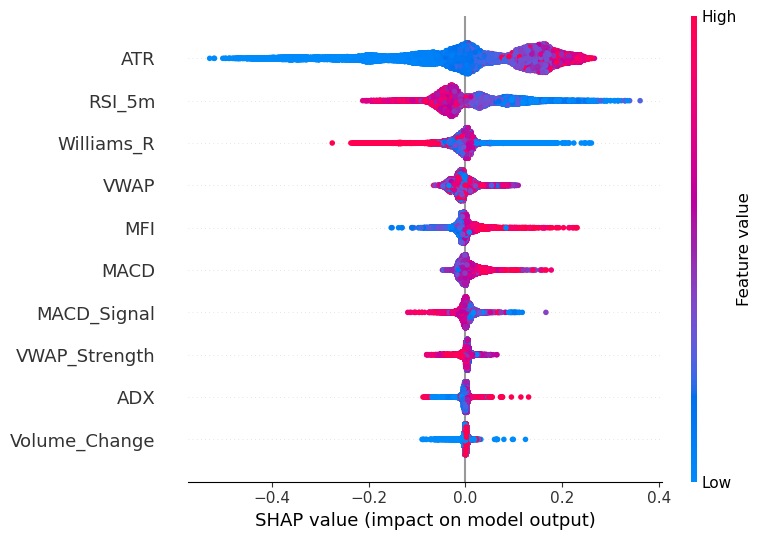

In [153]:
import shap
# Initialize SHAP explainer
explainer = shap.Explainer(model)
shap_values = explainer(X_test)

# Plot feature importance
shap.summary_plot(shap_values, X_test)

In [119]:
# Count occurrences of each class (0: Down, 1: Up)
class_counts = np.bincount(y_train)
print(f"Class 0 (Down) Count: {class_counts[0]}")
print(f"Class 1 (Up) Count: {class_counts[1]}")

# Calculate imbalance ratio
imbalance_ratio = class_counts[0] / class_counts[1]
print(f"Imbalance Ratio: {imbalance_ratio:.2f}")  # If > 2.0, it's highly imbalanced

Class 0 (Down) Count: 83811
Class 1 (Up) Count: 60860
Imbalance Ratio: 1.38


In [121]:
selected_features = ["Volatility_15m", "RSI_5m", "VWAP", "Volume_5m_Sum", "RSI_15m", "MACD", "MACD_Signal"]
X_train_selected = X_train[selected_features]
X_test_selected = X_test[selected_features]

In [122]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report

# Train XGBoost with optimized features
model_optimized = XGBClassifier(n_estimators=200, max_depth=6, learning_rate=0.01, random_state=42)
model_optimized.fit(X_train_selected, y_train)

# Predict
y_pred_optimized = model_optimized.predict(X_test_selected)

# Evaluate Performance
accuracy = accuracy_score(y_test, y_pred_optimized)
print(f"Optimized Model Accuracy: {accuracy:.2f}")
print(classification_report(y_test, y_pred_optimized))

Optimized Model Accuracy: 0.58
              precision    recall  f1-score   support

           0       0.58      0.96      0.72     20778
           1       0.52      0.05      0.10     15390

    accuracy                           0.58     36168
   macro avg       0.55      0.51      0.41     36168
weighted avg       0.55      0.58      0.46     36168



/opt/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:605: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:614: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:605: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:614: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or 

In [123]:
import numpy as np
from sklearn.metrics import precision_recall_curve

# Get probability predictions
y_probs = model.predict_proba(X_test)[:, 1]

# Find the best threshold using precision-recall curve
precisions, recalls, thresholds = precision_recall_curve(y_test, y_probs)

# Choose a threshold that increases recall while keeping precision reasonable
best_threshold = 0.35  # Lowering from 0.5 to catch more "Up" trades

# Apply the new threshold
y_pred_adjusted = (y_probs > best_threshold).astype(int)

# Evaluate the model with the new threshold
from sklearn.metrics import classification_report

print(f"Optimized Decision Threshold: {best_threshold}")
print(classification_report(y_test, y_pred_adjusted))

Optimized Decision Threshold: 0.35
              precision    recall  f1-score   support

           0       0.72      0.07      0.13     20778
           1       0.43      0.96      0.60     15390

    accuracy                           0.45     36168
   macro avg       0.58      0.52      0.36     36168
weighted avg       0.60      0.45      0.33     36168



/opt/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:605: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:614: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:605: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:614: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or 

In [ ]:
import talib

# Compute new trend & order flow indicators
df_1m["ATR"] = talib.ATR(df_1m["high"], df_1m["low"], df_1m["close"], timeperiod=14)  # Average True Range
df_1m["MFI"] = talib.MFI(df_1m["high"], df_1m["low"], df_1m["close"], df_1m["volume"], timeperiod=14)  # Money Flow Index
df_1m["ADX"] = talib.ADX(df_1m["high"], df_1m["low"], df_1m["close"], timeperiod=14)  # Trend Strength
df_1m["CMO"] = talib.CMO(df_1m["close"], timeperiod=14)  # Chande Momentum Oscillator
df_1m["Williams_R"] = talib.WILLR(df_1m["high"], df_1m["low"], df_1m["close"], timeperiod=14)  # Overbought/Oversold

# Compute VWAP-based strength signal
df_1m["VWAP_Strength"] = (df_1m["close"] - df_1m["VWAP"]) / df_1m["VWAP"]

# Compute volume delta (difference between buys and sells)
df_1m["Volume_Change"] = df_1m["volume"].diff()

# Select only important features
selected_features = ["RSI_5m", "MACD", "MACD_Signal", "VWAP", "ATR", "MFI", "ADX", "Williams_R", "VWAP_Strength", "Volume_Change"]
X_train_selected = X_train[selected_features]
X_test_selected = X_test[selected_features]

# Retrain the model
model.fit(X_train_selected, y_train)

KeyError: "['ATR', 'MFI', 'ADX', 'Williams_R', 'VWAP_Strength', 'Volume_Change'] not in index"